In [7]:
import sys
from os.path import dirname
sys.path.append(dirname("/home/nannau/msc/DoWnGAN/"))


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import xarray as xr
import numpy as np
import torch
import glob

from dataloader import NetCDFSR, xr_standardize_field, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch
import datetime
import pandas as pd
from prep_gan import find_nearest_index, to_utc

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.interpolate import NearestNDInterpolator

import seaborn as sns


import matplotlib.pyplot as plt

plt.style.use(['science','no-latex'])
plt.rcParams.update({"figure.figsize":  (5,10),
                    'font.family': 'Times New Roman',
                    'font.size': 25,
                    'lines.linewidth': 2.5})


from models.generator import Generator
from models.critic import Critic
# import geopandas as gpd

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client=Client(n_workers=4, threads_per_worker=1, memory_limit="4GB")
client

/home/nannau/tri/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44099 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42743 Dashboard: http://127.0.0.1:44099/status,Cluster Workers: 4 Cores: 4 Memory: 14.90 GiB


In [11]:
hr_dataroot_U10 = "../data/wrf/U10/regrid_10_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "../data/wrf/V10/regrid_10_6hrly_wrf2d_d01_ctrl_V10*.nc"

hr_dataroot_U10 = "../data/wrf/U10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_U10*.nc"
hr_dataroot_V10 = "../data/wrf/V10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_V10*.nc"

fine_u = xr.open_mfdataset(glob.glob(hr_dataroot_U10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})
fine_v = xr.open_mfdataset(glob.glob(hr_dataroot_V10), combine='by_coords', engine='netcdf4', concat_dim='Time', chunks={"Times":10})

dataroot = "../data/interim_2000-10-01_to_2013-09-30.nc"

target = '10UV_GDS4_SFC'
coarse = xr.open_dataset(dataroot).astype("float")
coarse = coarse.sortby('latitude', ascending=True)
coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

# scale factor
sf = 8

In [16]:
Times_dt = []
for t in fine_u.Times:
    year = int(str(float(t))[:4])
    month = int(str(float(t))[4:6])
    day = int(str(float(t))[6:8])
    hours = int(np.round(24*float(str(float(t))[8:])))
    Times_dt.append(np.datetime64(datetime.datetime(year, month, day, hours)))
Times_dt = np.array(Times_dt).astype('datetime64[D]')
Times_dt_pd = pd.DatetimeIndex(Times_dt)
filter_func = np.vectorize(lambda x: True if x.month in [6, 7, 8, 9, 10] else False)
time_mask = filter_func(Times_dt_pd.astype(object))

i_list = np.arange(len(time_mask))
i_list[time_mask]

time_mask = np.ones(time_mask.shape) == 1
time_mask[18000:] = False

In [17]:
low, up, l, r = 4, 20, 70, 86

In [18]:
u10 = fine_u.U10[time_mask, sf*low:sf*up, sf*l:sf*r]
v10 = fine_v.V10[time_mask, sf*low:sf*up, sf*l:sf*r]

coarse_u10 = coarse.u10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})
coarse_v10 = coarse.v10.loc["2000-01-01":"2015-05-30"].chunk({"time": 10})

coarse_u10_patch = coarse_u10[time_mask, low:up, l:r]
coarse_v10_patch = coarse_v10[time_mask, low:up, l:r]

u10 = xr_standardize_field(u10)
v10 = xr_standardize_field(v10)
coarse_u10 =  xr_standardize_field(coarse_u10_patch)
coarse_v10 =  xr_standardize_field(coarse_v10_patch)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


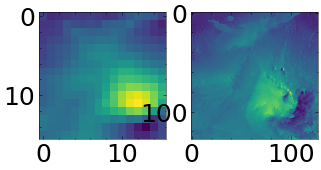

In [19]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[18, ...])
ax[1].imshow(u10[18, ...])

In [20]:
coarse = np.stack([coarse_u10, coarse_v10], axis=1)
fine = np.stack([u10, v10], axis=1)

In [21]:
fine_t = torch.from_numpy(fine)#.double()
coarse_t = torch.from_numpy(coarse)#.double()

In [22]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

class NetCDFSR(Dataset):
    """Data loader for netCDF data for GAN Super Resolution"""

    def __init__(
        self,
        fine,
        coarse,
        times,
        device = device):
        """
        Args:
            mdsarr (xarray.MultiDataset): fine scale dataset
            mdscoarse (xarray.MultiDataset): fine coarse scale dataset
            transforms (torch.transform.Compose): default None, preprocessing image transforms
            norm (bool): whether to normalize/standardize data
            mean (float): which mean to standardize to
            std (float): which stdev to standardize to
        """
        self.fine = fine[times, ...]#.to(device)
        self.coarse = coarse[times, ...]#.to(device)

    def __len__(self):
        return self.fine.shape[0]
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        arr = self.fine[idx, ...]
        carr = self.coarse[idx, ...]

#         arr = torch.unsqueeze(arr, 0)
#         carr = torch.unsqueeze(carr, 0)

#         arr = torch.from_numpy(arr)#.long().float()
#         carr = torch.from_numpy(carr)#.long().float()

        return arr, carr

dataset = NetCDFSR(
    fine_t,
    coarse_t,
    i_list[time_mask][:1000],
    device=device,
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1000,
    shuffle=True
)

real_batch, real_cbatch = next(iter(dataloader))
fixed = {"coarse": real_cbatch, "fine": real_batch}
fixed["coarse"].size()

torch.Size([1000, 2, 16, 16])

In [23]:
import mlflow
hashed = "5347f0446e364ece98f3d652436f8462"
logged_model = f'file:///home/nannau/msc/DoWnGAN/mlruns/1/{hashed}/artifacts/Generator'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
G = mlflow.pytorch.load_model(logged_model).to(device)

# state_dict_uri = mlflow.get_artifact_uri(artifact_path)
state_dict = mlflow.pytorch.load_state_dict(logged_model)#state_dict.pth")
G.load_state_dict(state_dict)
# loaded_model(fixed["coarse"].to(device))

<All keys matched successfully>

In [24]:
batch_size=64
i = np.random.randint(0, batch_size)

In [25]:
real = fixed["fine"][i, 1, ...].detach().numpy()
coarse = fixed["coarse"][i, 1, ...].detach().numpy()

Text(0.5, 1.0, 'Ground Truth')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


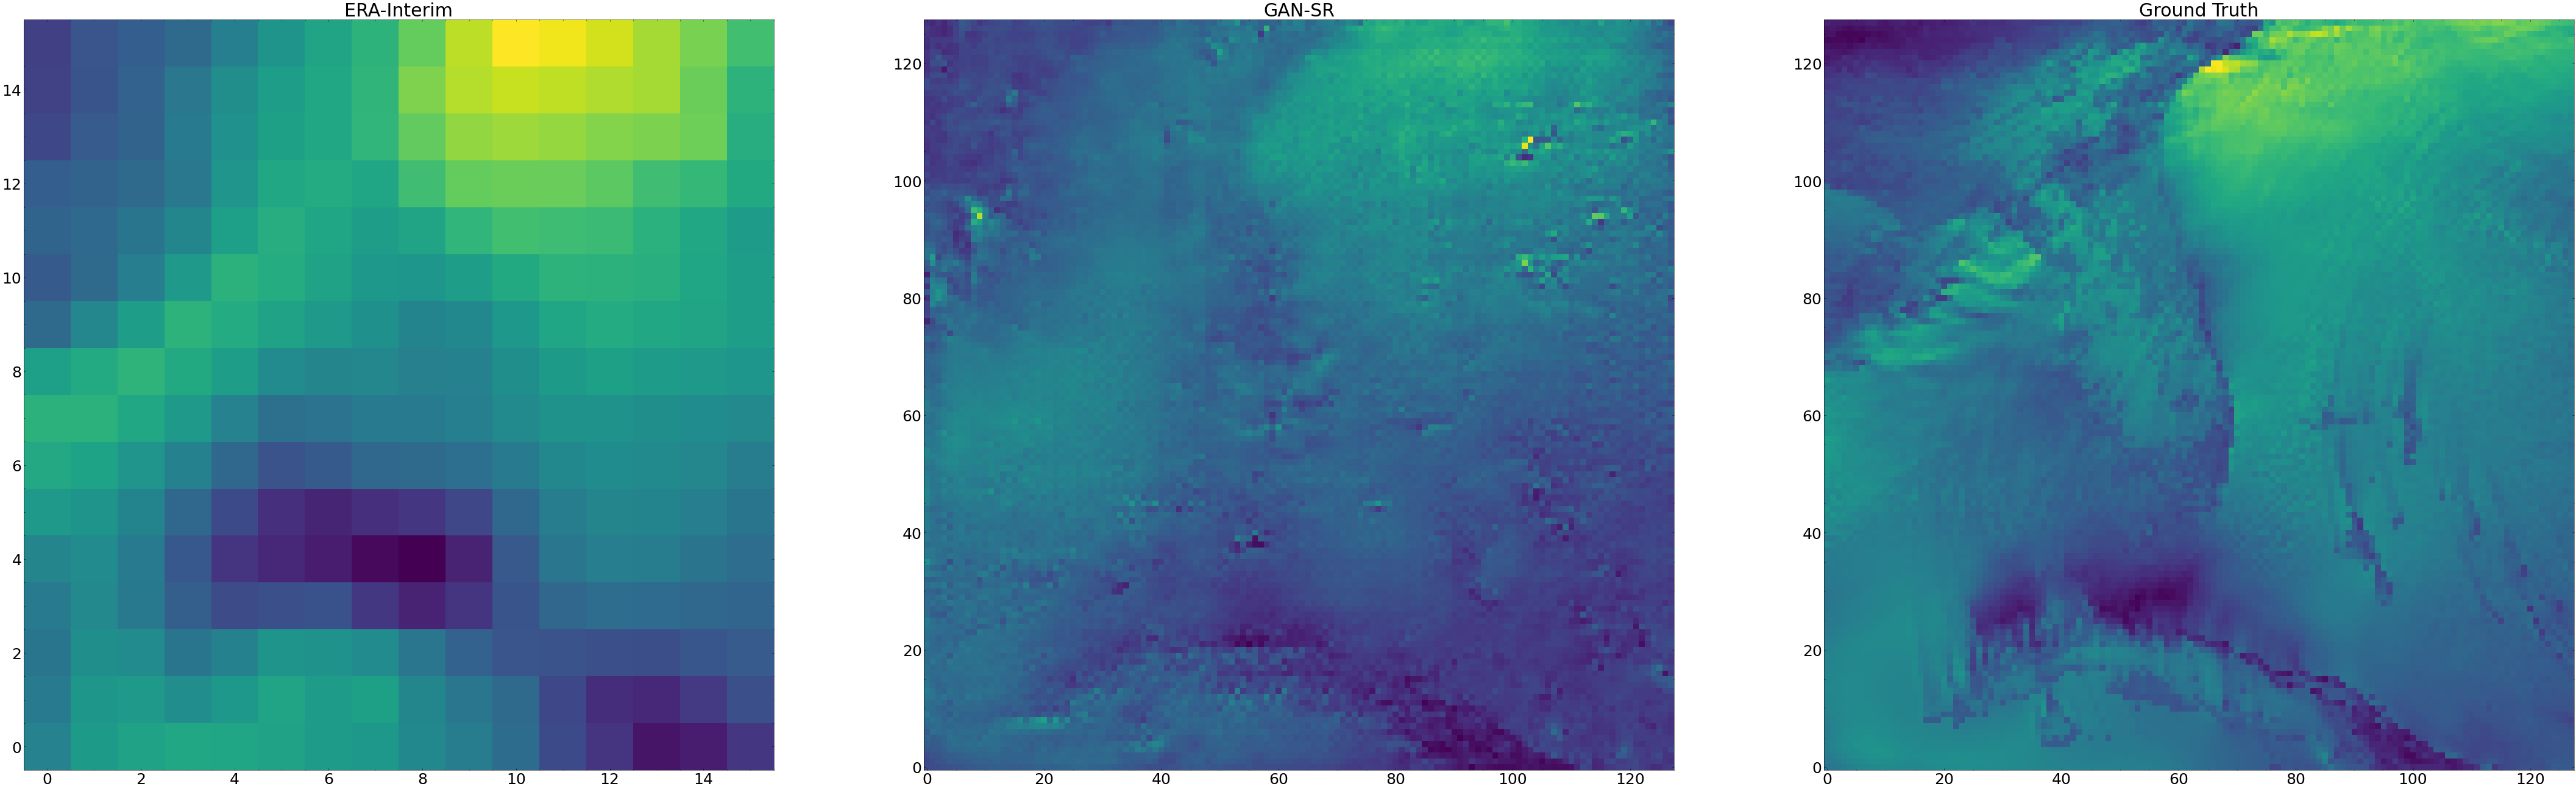

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(75, 75))
# np.random.seed(500)
i = np.random.randint(0, batch_size)

N1 = 3
N2 = N1+3
    
# i = np.random.randint(0, batch_size)

# real = fixed["fine"][i, 1, ...].detach().numpy()
# coarse = fixed["coarse"][i, 1, ...].detach().numpy()

coarse_hypot = np.hypot(
    fixed["coarse"][i, 0, ...].detach().numpy(),
    fixed["coarse"][i, 1, ...].detach().numpy()
)

u10_fake = G(fixed["coarse"].float().to(device))[i, 0, ...].detach().cpu().numpy()
v10_fake = G(fixed["coarse"].float().to(device))[i, 1, ...].detach().cpu().numpy()

real = fixed["fine"][i, 1, ...].detach().numpy()

u10_real = fixed["fine"][i, 0, ...].detach().numpy()
v10_real = fixed["fine"][i, 1, ...].detach().numpy()

speed_fake = np.hypot(u10_fake, v10_fake)
speed_real = np.hypot(u10_real, v10_real)

#     flin = interp2d(x, y, coarse, kind='linear')
#     naive_lin = flin(nx, ny)

# Regressing leading EOFs
#     reg = LinearRegression().fit(fine_sp_basis_v10.T, real.flatten())
#     leading_eofs = reg.predict(fine_sp_basis_v10.T).reshape(real.shape)

ax[0].imshow(coarse_hypot, origin="lower")
ax[0].set_title("ERA-Interim")
ax[1].imshow(speed_fake, origin="lower")
ax[1].set_title("GAN-SR")
ax[2].imshow(speed_real, origin="lower")
ax[2].set_title("Ground Truth")

In [27]:
from scipy.interpolate import interp2d
x = np.arange(coarse.shape[0])
y = np.arange(coarse.shape[1])
nx = np.linspace(x.min(), x.max(), sf*x.shape[0])
ny = np.linspace(y.min(), y.max(), sf*y.shape[0])

In [30]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=9, stride=1, padding=4, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        # x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        x = x.contiguous().view(x.size()[:4] + (-1,)).mean(dim=-1)[0]
        return x

In [31]:
med = MedianPool2d()

In [39]:
fixed["fine"][0, 0, ...].size()


torch.Size([128, 128])

In [48]:
med_fine = med(fixed["fine"][0, ...].to(device))

AssertionError: 3D tensors expect 2 values for padding

In [45]:
med_fine.size()

torch.Size([2, 128, 128])

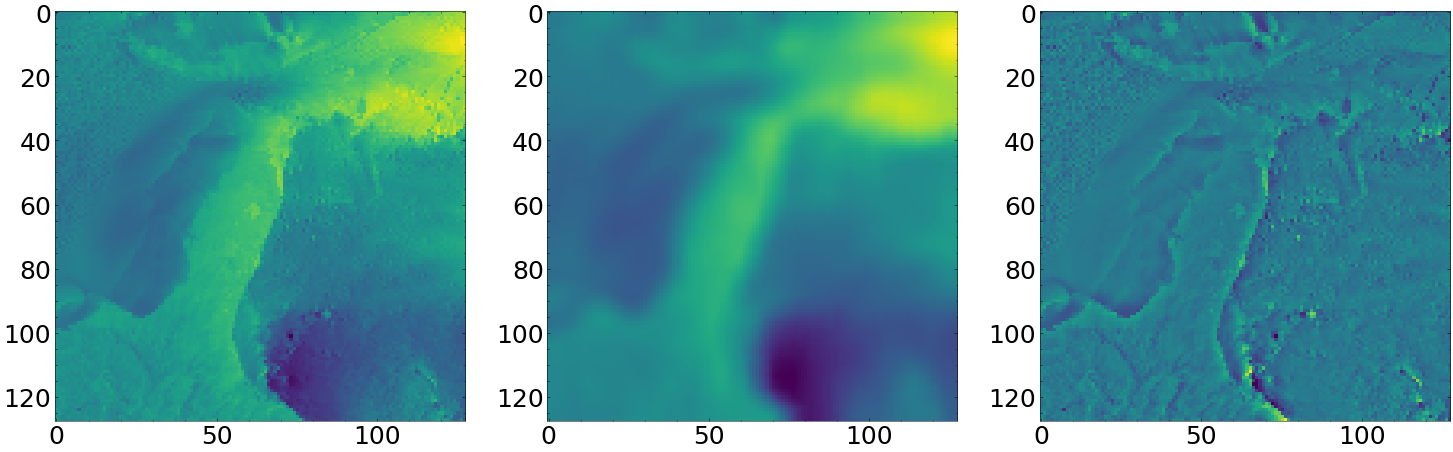

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(25, 40))
ax[0].imshow(fixed["fine"][0, 0, ...])
ax[1].imshow(med_fine[0, ...].cpu().detach().numpy())
ax[2].imshow(fixed["fine"][0, 0, ...]-med_fine[0, ...].cpu().detach().numpy())